/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


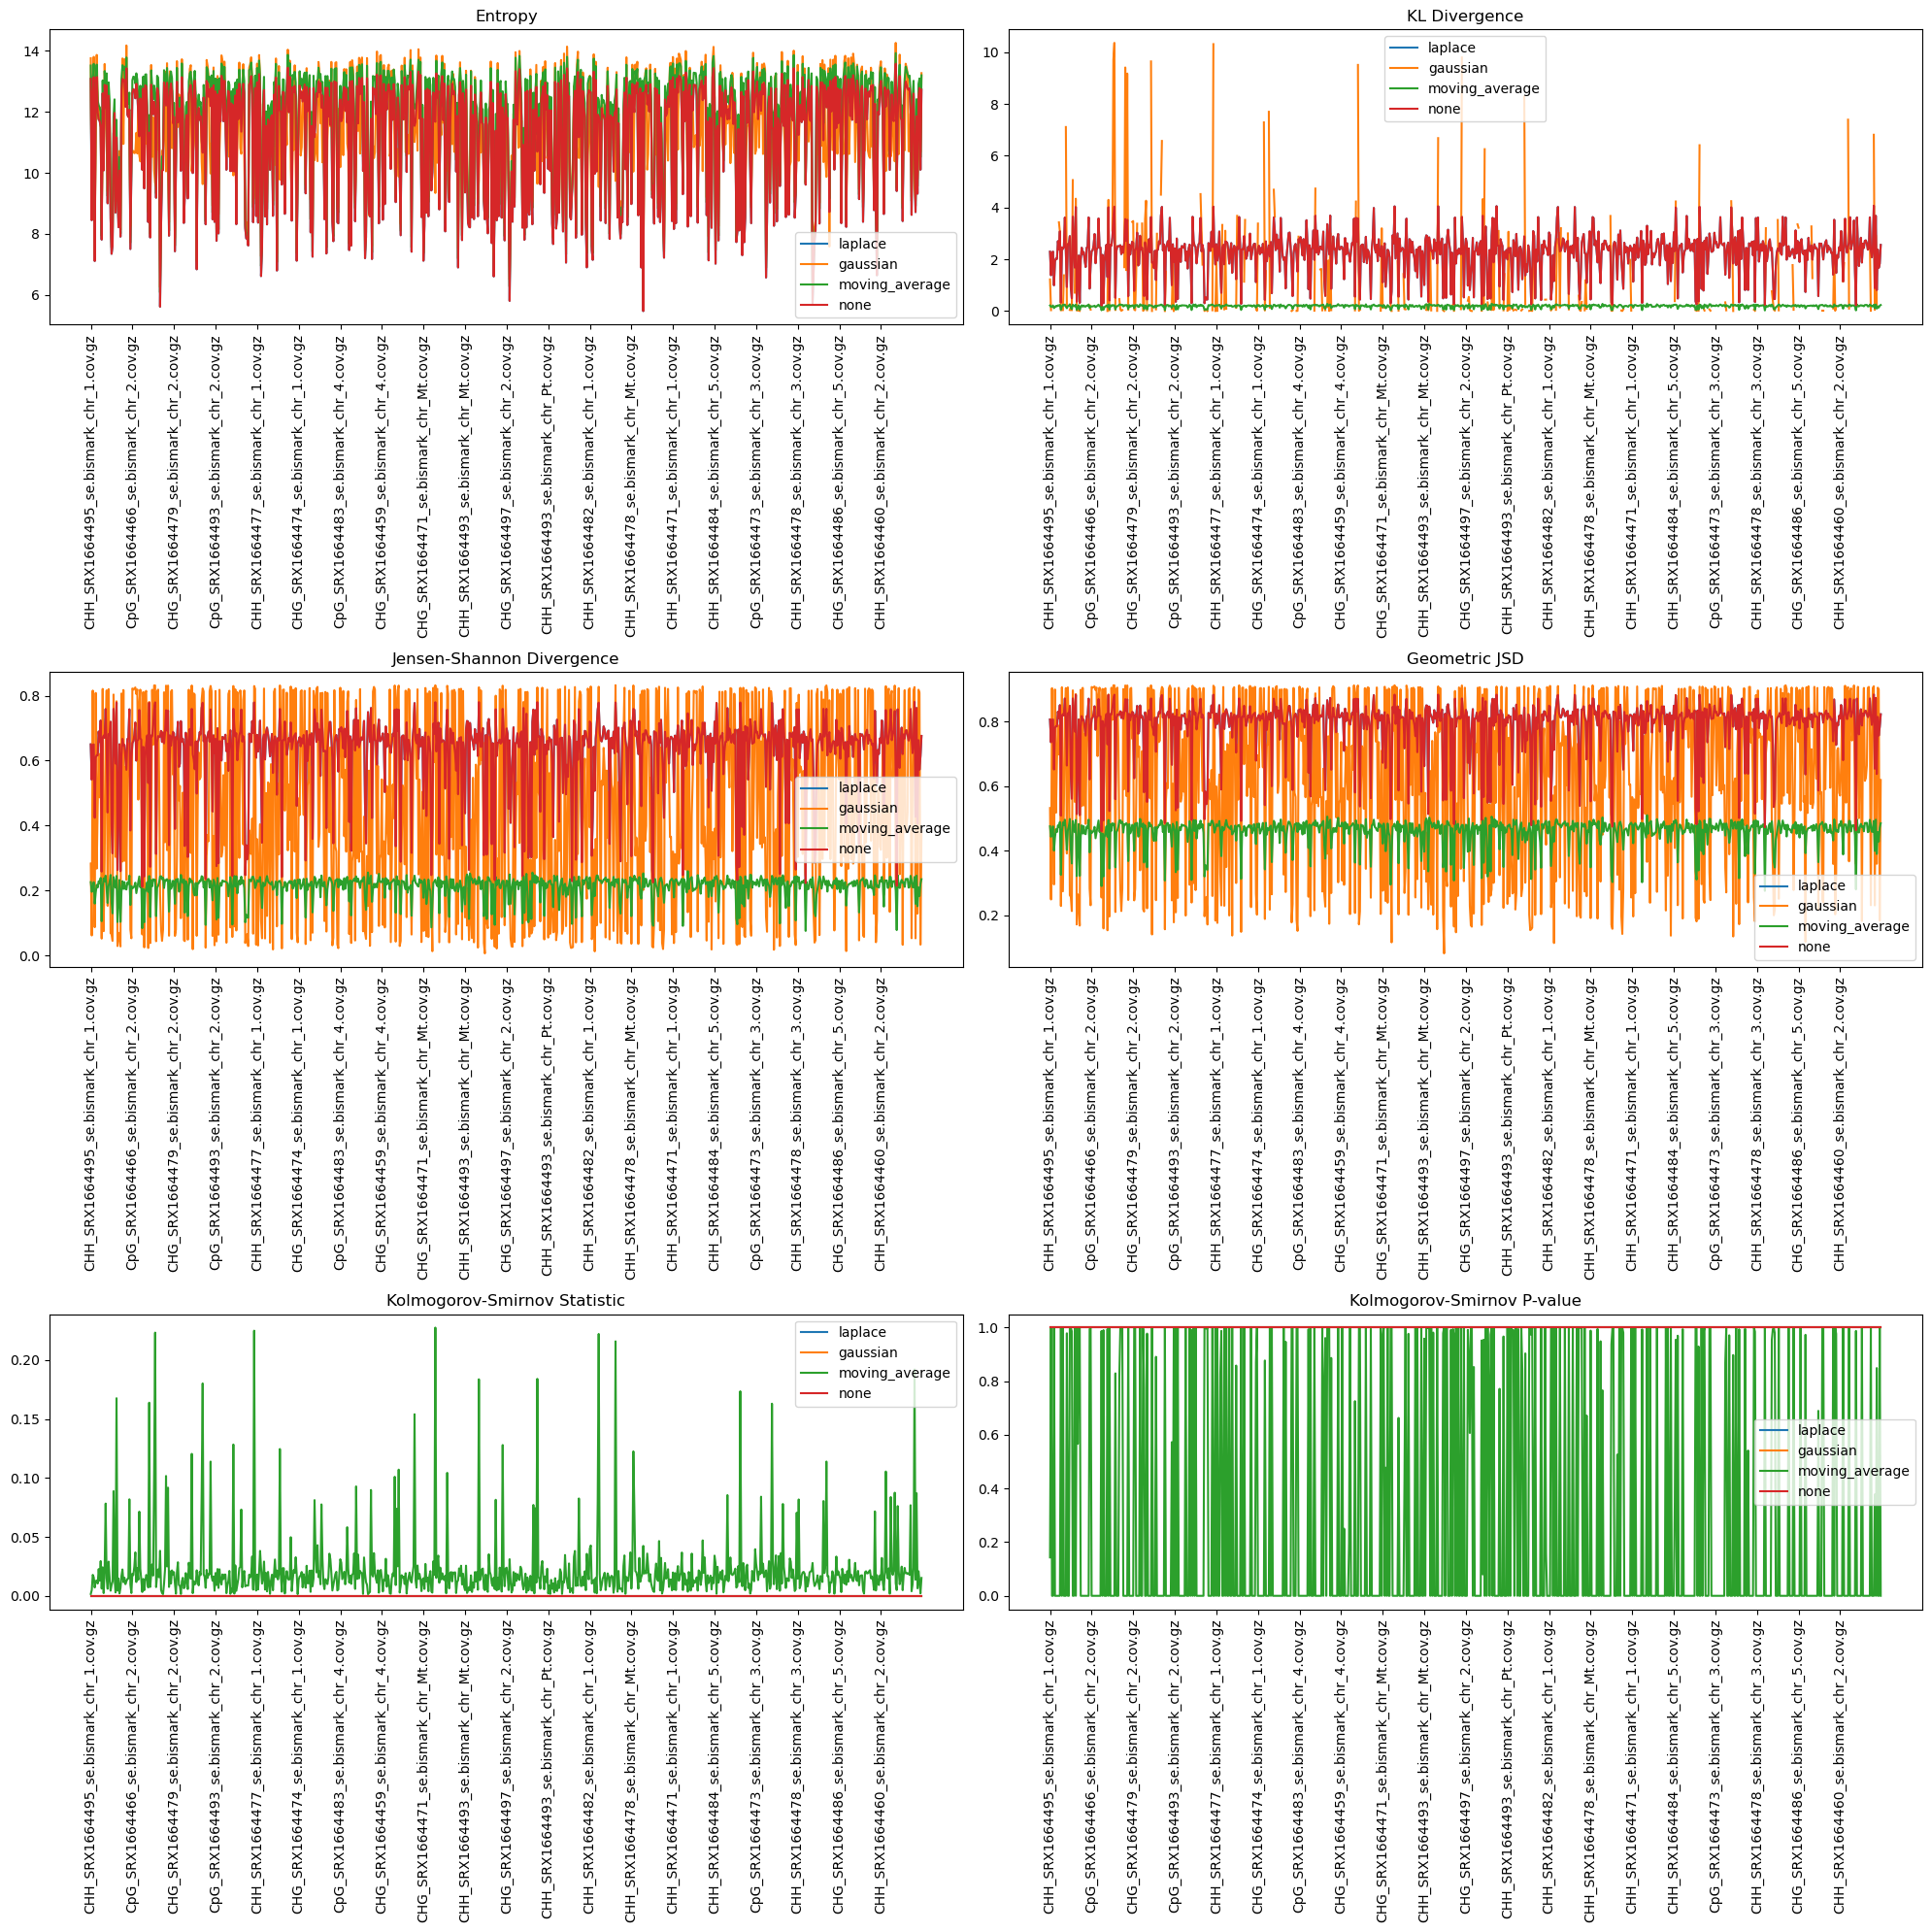

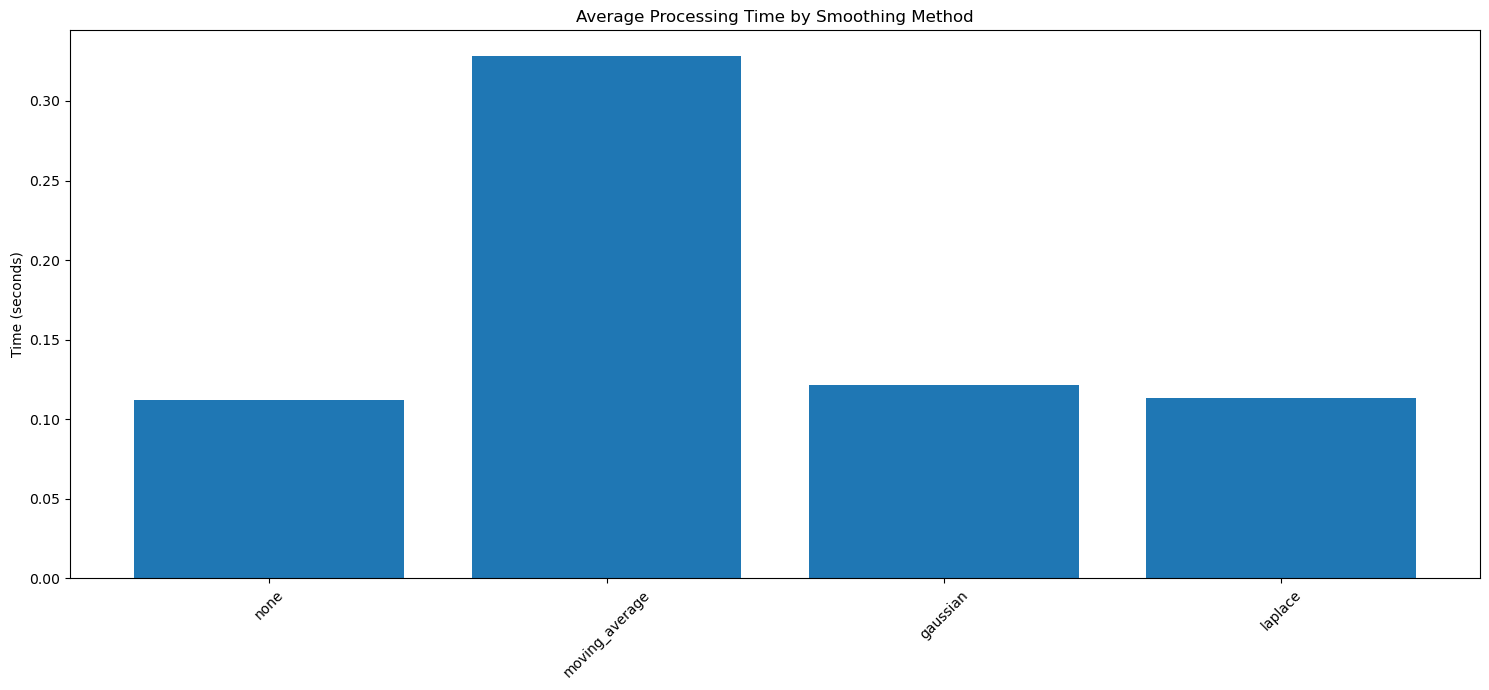

ANOVA test result: F_onewayResult(statistic=294.81336981732113, pvalue=7.223631956076505e-170)


In [2]:
import pandas as pd
import numpy as np
import os
import gzip
import time
import zipfile
from scipy.stats import entropy, ks_2samp, f_oneway
from scipy.special import rel_entr
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import jensenshannon

# Function to calculate KL divergence
def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

# Function to calculate geometric Jensen-Shannon divergence
def geometric_jsd(p, q):
    jsd = jensenshannon(p, q)
    return np.sqrt(jsd)

# Function to perform Kolmogorov-Smirnov test
def ks_test(p, q):
    ks_result = ks_2samp(p, q)
    return ks_result.statistic, ks_result.pvalue

# Smoothing functions
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def gaussian_smoothing(data, sigma=10):  # Adjusted sigma for smaller range
    return np.exp(-np.square(data - np.mean(data)) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def laplace_smoothing(data, alpha=1e-10):  # Much smaller alpha for more realistic smoothing
    return (data + alpha) / (np.sum(data) + alpha * len(data))

def good_turing_smoothing(data):
    unique, counts = np.unique(data, return_counts=True)
    freq_of_freqs = np.bincount(counts)
    smoothed = np.array([((c+1) * (freq_of_freqs[c+1]/freq_of_freqs[c]) if c+1 < len(freq_of_freqs) else c) for c in counts])
    return smoothed / np.sum(smoothed)

def lowess_smoothing(data, frac=0.01):  # Further reduced fraction for faster computation
    return lowess(data, np.arange(len(data)), frac=frac)[:, 1]

def hmm_smoothing(data, n_components=2):
    model = GaussianMixture(n_components=n_components, max_iter=100)  # Reduced max_iter for faster computation
    data_reshaped = data.reshape(-1, 1)
    model.fit(data_reshaped)
    smoothed = model.predict_proba(data_reshaped)[:, 1]
    return smoothed

# Function to apply smoothing
def apply_smoothing(data, method):
    if method == 'moving_average':
        return moving_average(data)
    elif method == 'gaussian':
        return gaussian_smoothing(data)
    elif method == 'laplace':
        return laplace_smoothing(data)
    elif method == 'good_turing':
        return good_turing_smoothing(data)
    elif method == 'lowess':
        return lowess_smoothing(data)
    elif method == 'hmm':
        return hmm_smoothing(data)
    elif method == 'none':
        return data
    else:
        raise ValueError(f"Unknown smoothing method: {method}")

# Function to calculate divergence metrics
def divergence_calculations(data, smoothing='laplace'):
    # Filter out zero values in methylated and unmethylated counts
    data = data[(data['methylated'] > 0) & (data['unmethylated'] > 0)]

    # Calculate the statistics for the entire dataset
    p = data[['methylated', 'unmethylated']].values.flatten().astype(np.float64)
    q = data[['unmethylated', 'methylated']].values.flatten().astype(np.float64)

    # Apply smoothing if not 'none'
    if smoothing != 'none':
        p = apply_smoothing(p, smoothing)
        q = apply_smoothing(q, smoothing)

    # Normalize p and q
    p /= p.sum()
    q /= q.sum()

    kl = kl_divergence(p, q)
    js = jensenshannon(p, q)
    gjs = geometric_jsd(p, q)
    ks_stat, ks_pvalue = ks_test(p, q)

    dataset_result = {
        'entropy': entropy(p),
        'relative_entropy': kl,  # KL divergence is relative entropy
        'jsd': js,
        'geometric_jsd': gjs,
        'kolmogorov_smirnov_stat': ks_stat,
        'kolmogorov_smirnov_pvalue': ks_pvalue
    }
    return dataset_result

# Function to process input files
def process_file(file_path):
    with gzip.open(file_path, 'rt') as f:
        df = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'methylated', 'unmethylated', 'percentage'])
    return df

# Function to analyze samples
def analyze_samples(base_dir, smoothing_methods, save_interval=100):
    results = {}
    times = {method: [] for method in smoothing_methods}

    file_counter = 0
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.cov.gz'):
                file_path = os.path.join(root, file)
                #print(f"Processing file: {file_path}")
                data = process_file(file_path)
                
                for method in smoothing_methods:
                    #print(f"Testing method: {method}")
                    start_time = time.time()
                    result = divergence_calculations(data, smoothing=method)
                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    times[method].append(elapsed_time)
                    results[(file, method)] = result
                
                file_counter += 1

                # Save interim results periodically
                if file_counter % save_interval == 0:
                    save_results(results, times, 'interim_results.zip')

    # Save the final results
    save_results(results, times, 'final_results.zip')
    return results, times

# Function to save results to a zip file
def save_results(results, times, zip_file):
    results_df = pd.DataFrame(results).T
    results_df.to_csv('results.csv', index=True)
    
    times_df = pd.DataFrame(times)
    times_df.to_csv('times.csv', index=True)

    with zipfile.ZipFile(zip_file, 'w') as zipf:
        zipf.write('results.csv')
        zipf.write('times.csv')

    os.remove('results.csv')
    os.remove('times.csv')

# Function to plot results
def plot_results(results, times):
    methods = list(set(key[1] for key in results.keys()))
    files = list(set(key[0] for key in results.keys()))

    entropies = {method: [] for method in methods}
    kl_divergences = {method: [] for method in methods}
    jsds = {method: [] for method in methods}
    geometric_jsds = {method: [] for method in methods}
    ks_statistics = {method: [] for method in methods}
    ks_pvalues = {method: [] for method in methods}

    for file in files:
        for method in methods:
            result = results.get((file, method))
            if result:
                entropies[method].append(result['entropy'])
                kl_divergences[method].append(result['relative_entropy'])
                jsds[method].append(result['jsd'])
                geometric_jsds[method].append(result['geometric_jsd'])
                ks_statistics[method].append(result['kolmogorov_smirnov_stat'])
                ks_pvalues[method].append(result['kolmogorov_smirnov_pvalue'])

    x = np.arange(len(files))

    fig, axs = plt.subplots(3, 2, figsize=(20, 20))  # Increased figure size

    for method in methods:
        axs[0, 0].plot(x, entropies[method], label=method)
        axs[0, 1].plot(x, kl_divergences[method], label=method)
        axs[1, 0].plot(x, jsds[method], label=method)
        axs[1, 1].plot(x, geometric_jsds[method], label=method)
        axs[2, 0].plot(x, ks_statistics[method], label=method)
        axs[2, 1].plot(x, ks_pvalues[method], label=method)

    axs[0, 0].set_title('Entropy')
    axs[0, 1].set_title('KL Divergence')
    axs[1, 0].set_title('Jensen-Shannon Divergence')
    axs[1, 1].set_title('Geometric JSD')
    axs[2, 0].set_title('Kolmogorov-Smirnov Statistic')
    axs[2, 1].set_title('Kolmogorov-Smirnov P-value')

    for ax in axs.flat:
        ax.set_xticks(x[::max(1, len(x))])  # Show a subset of labels to avoid clutter
        ax.set_xticklabels(files[::max(1, len(x))], rotation=90)  # Rotate labels for better readability
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Plotting the times for each method
    fig, ax = plt.subplots(figsize=(15, 7))
    avg_times = {method: np.mean(times[method]) for method in times}
    ax.bar(avg_times.keys(), avg_times.values())
    ax.set_title('Average Processing Time by Smoothing Method')
    ax.set_ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ANOVA test to compare times between different smoothing methods
    time_values = [times[method] for method in times]
    anova_result = f_oneway(*time_values)
    print("ANOVA test result:", anova_result)

# Sample directory path
base_dir = '/home/eharpu/methylation_analysis/samples_testing'
smoothing_methods = ['none', 'moving_average', 'gaussian', 'laplace']
results, times = analyze_samples(base_dir, smoothing_methods)
plot_results(results, times)


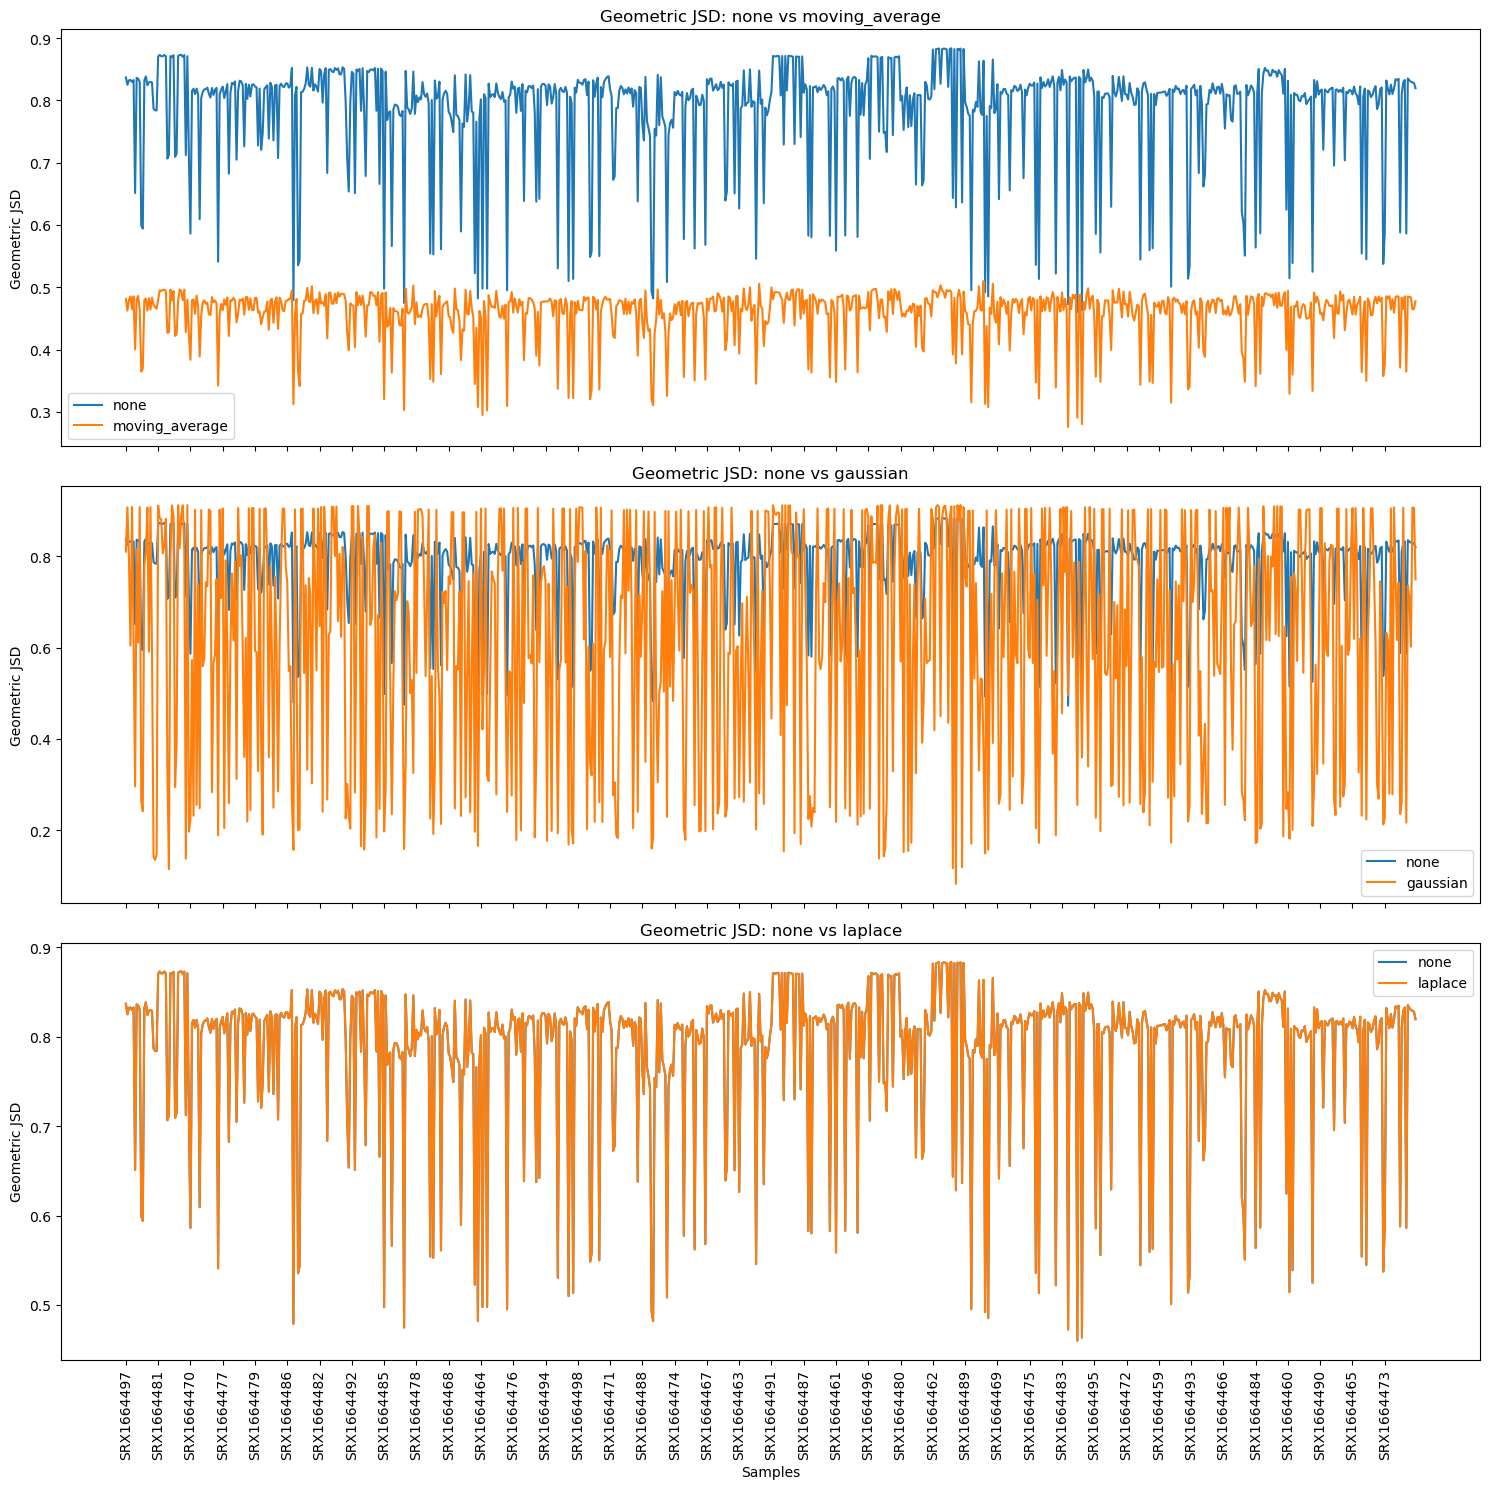

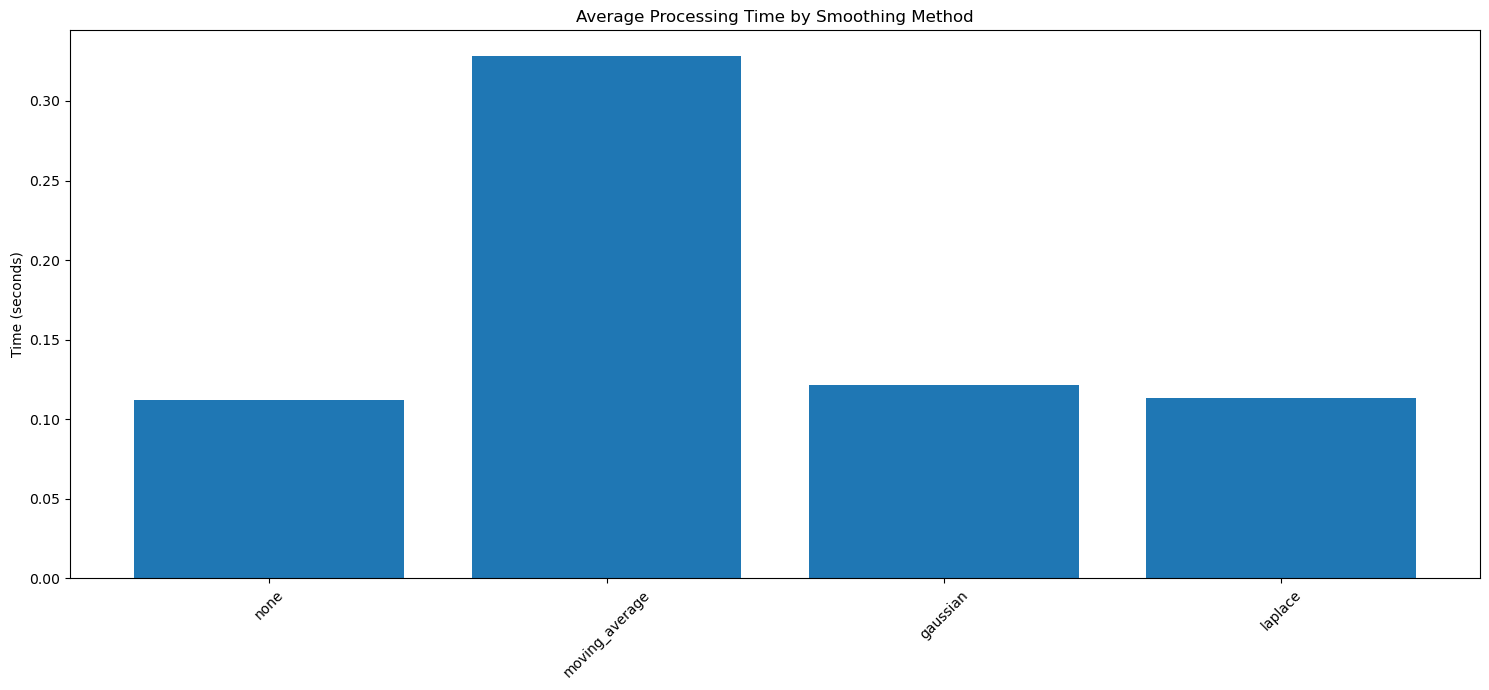

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

def read_results_from_csv(results_file):
    results_df = pd.read_csv(results_file)
    return results_df

# Extract sample number from file name
def extract_sample_number(file_name):
    parts = file_name.split('_')
    return parts[1] if len(parts) > 1 else file_name

def plot_geometric_jsd_subplots(results_df):
    methods = results_df['Unnamed: 1'].unique()
    files = results_df['Unnamed: 0'].unique()
    
    sample_numbers = [extract_sample_number(file) for file in files]

    geometric_jsds = {method: [] for method in methods}
    geometric_jsds_none = []

    for file in files:
        none_result = results_df[(results_df['Unnamed: 0'] == file) & (results_df['Unnamed: 1'] == 'none')]
        if not none_result.empty:
            geometric_jsds_none.append(none_result['geometric_jsd'].values[0])
            for method in methods:
                if method != 'none':
                    result = results_df[(results_df['Unnamed: 0'] == file) & (results_df['Unnamed: 1'] == method)]
                    if not result.empty:
                        geometric_jsds[method].append(result['geometric_jsd'].values[0])

    x = np.arange(len(files))
    
    num_subplots = len(methods) - 1
    fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 5 * num_subplots), sharex=True)  

    if num_subplots == 1:
        axs = [axs]  

    subplot_index = 0
    for method in methods:
        if method != 'none':
            ax = axs[subplot_index]
            ax.plot(x, geometric_jsds_none, label='none')
            ax.plot(x, geometric_jsds[method], label=method)
            ax.set_title(f'Geometric JSD: none vs {method}')
            ax.set_ylabel('Geometric JSD')
            ax.legend()
            subplot_index += 1

    axs[-1].set_xticks(x[::max(1, len(x)//40)])  
    axs[-1].set_xticklabels(sample_numbers[::max(1, len(x)//40)], rotation=90)  
    axs[-1].set_xlabel('Samples')

    plt.tight_layout()
    plt.show()

# Function to plot processing times
def plot_processing_times(times_df):
    fig, ax = plt.subplots(figsize=(15, 7))
    avg_times = times_df.mean()
    ax.bar(avg_times.index, avg_times.values)
    ax.set_title('Average Processing Time by Smoothing Method')
    ax.set_ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

results_file = 'results.csv'
times_file = 'times.csv'

results_df = read_results_from_csv(results_file)
times_df = pd.read_csv(times_file, index_col=0)

plot_geometric_jsd_subplots(results_df)

plot_processing_times(times_df)


In [ ]:
import pandas as pd
import numpy as np
import os
import gzip
import time
import zipfile
from scipy.stats import entropy, ks_2samp, f_oneway
from scipy.special import rel_entr
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import jensenshannon

# Function to calculate KL divergence
def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

# Function to calculate geometric Jensen-Shannon divergence
def geometric_jsd(p, q):
    jsd = jensenshannon(p, q)
    return np.sqrt(jsd)

# Function to perform Kolmogorov-Smirnov test
def ks_test(p, q):
    ks_result = ks_2samp(p, q)
    return ks_result.statistic, ks_result.pvalue

# Smoothing functions
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def gaussian_smoothing(data, sigma=10):  # Adjusted sigma for smaller range
    return np.exp(-np.square(data - np.mean(data)) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def laplace_smoothing(data, alpha=1e-10):  # Much smaller alpha for more realistic smoothing
    return (data + alpha) / (np.sum(data) + alpha * len(data))

def good_turing_smoothing(data):
    unique, counts = np.unique(data, return_counts=True)
    freq_of_freqs = np.bincount(counts)
    smoothed = np.array([((c+1) * (freq_of_freqs[c+1]/freq_of_freqs[c]) if c+1 < len(freq_of_freqs) else c) for c in counts])
    return smoothed / np.sum(smoothed)

def lowess_smoothing(data, frac=0.01): 
    return lowess(data, np.arange(len(data)), frac=frac)[:, 1]

def hmm_smoothing(data, n_components=2):
    model = GaussianMixture(n_components=n_components, max_iter=100)  
    data_reshaped = data.reshape(-1, 1)
    model.fit(data_reshaped)
    smoothed = model.predict_proba(data_reshaped)[:, 1]
    return smoothed

# Function to apply smoothing
def apply_smoothing(data, method):
    if method == 'moving_average':
        return moving_average(data)
    elif method == 'gaussian':
        return gaussian_smoothing(data)
    elif method == 'laplace':
        return laplace_smoothing(data)
    elif method == 'good_turing':
        return good_turing_smoothing(data)
    elif method == 'lowess':
        return lowess_smoothing(data)
    elif method == 'hmm':
        return hmm_smoothing(data)
    elif method == 'none':
        return data
    else:
        raise ValueError(f"Unknown smoothing method: {method}")

# Function to calculate divergence metrics
def divergence_calculations(data, smoothing='laplace'):
    # Filter out zero values in methylated and unmethylated counts
    data = data[(data['methylated'] > 0) & (data['unmethylated'] > 0)]

    # Calculate the statistics for the entire dataset
    p = data[['methylated', 'unmethylated']].values.flatten().astype(np.float64)
    q = data[['unmethylated', 'methylated']].values.flatten().astype(np.float64)

    # Apply smoothing if not 'none'
    if smoothing != 'none':
        p = apply_smoothing(p, smoothing)
        q = apply_smoothing(q, smoothing)

    # Normalize p and q
    p /= p.sum()
    q /= q.sum()

    kl = kl_divergence(p, q)
    js = jensenshannon(p, q)
    gjs = geometric_jsd(p, q)
    ks_stat, ks_pvalue = ks_test(p, q)

    dataset_result = {
        'entropy': entropy(p),
        'relative_entropy': kl,  # KL divergence is relative entropy
        'jsd': js,
        'geometric_jsd': gjs,
        'kolmogorov_smirnov_stat': ks_stat,
        'kolmogorov_smirnov_pvalue': ks_pvalue
    }
    return dataset_result

# Function to process input files
def process_file(file_path):
    with gzip.open(file_path, 'rt') as f:
        df = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'methylated', 'unmethylated', 'percentage'])
    return df

# Function to analyze samples
def analyze_samples_old(base_dir, smoothing_methods, save_interval=100):
    results = {}
    times = {method: [] for method in smoothing_methods}

    file_counter = 0
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.cov.gz'):
                file_path = os.path.join(root, file)
                #print(f"Processing file: {file_path}")
                data = process_file(file_path)
                
                for method in smoothing_methods:
                    #print(f"Testing method: {method}")
                    start_time = time.time()
                    result = divergence_calculations(data, smoothing=method)
                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    times[method].append(elapsed_time)
                    results[(file, method)] = result
                
                file_counter += 1

                # Save interim results periodically
                if file_counter % save_interval == 0:
                    save_results(results, times, 'interim_results.zip')

    # Save the final results
    save_results(results, times, 'final_results.zip')
    return results, times

def analyze_samples(base_dir, smoothing_methods, save_interval=100):
    results = {}
    times = {method: [] for method in smoothing_methods}

    file_counter = 0
    folder_counter = 0
    for root, dirs, files in os.walk(base_dir):
        if folder_counter >= 2:
            break

        for file in files:
            if file.endswith('.cov.gz'):
                file_path = os.path.join(root, file)
                print(f"Processing file: {file_path}")  # Add logging

                try:
                    data = process_file(file_path)  # Use your process_file function

                    for method in smoothing_methods:
                        print(f"Testing method: {method}")  # Add logging
                        start_time = time.time()
                        result = divergence_calculations(data, smoothing=method)
                        end_time = time.time()
                        elapsed_time = end_time - start_time
                        times[method].append(elapsed_time)
                        results[(file, method)] = result
                        
                    file_counter += 1

                    # Save interim results periodically
                    if file_counter % save_interval == 0:
                        save_results(results, times, 'interim_results.zip')

                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

        folder_counter += 1

    # Save final results
    save_results(results, times, 'final_results.zip')
    return results, times

# Function to save results to a zip file
def save_results(results, times, zip_file):
    results_df = pd.DataFrame(results).T
    results_df.to_csv('results.csv', index=True)
    
    times_df = pd.DataFrame(times)
    times_df.to_csv('times.csv', index=True)

    with zipfile.ZipFile(zip_file, 'w') as zipf:
        zipf.write('results.csv')
        zipf.write('times.csv')

    os.remove('results.csv')
    os.remove('times.csv')

# Function to plot results
def plot_results(results, times):
    methods = list(set(key[1] for key in results.keys()))
    files = list(set(key[0] for key in results.keys()))

    entropies = {method: [] for method in methods}
    kl_divergences = {method: [] for method in methods}
    jsds = {method: [] for method in methods}
    geometric_jsds = {method: [] for method in methods}
    ks_statistics = {method: [] for method in methods}
    ks_pvalues = {method: [] for method in methods}

    for file in files:
        for method in methods:
            result = results.get((file, method))
            if result:
                entropies[method].append(result['entropy'])
                kl_divergences[method].append(result['relative_entropy'])
                jsds[method].append(result['jsd'])
                geometric_jsds[method].append(result['geometric_jsd'])
                ks_statistics[method].append(result['kolmogorov_smirnov_stat'])
                ks_pvalues[method].append(result['kolmogorov_smirnov_pvalue'])

    x = np.arange(len(files))

    fig, axs = plt.subplots(3, 2, figsize=(20, 20))  # Increased figure size

    for method in methods:
        axs[0, 0].plot(x, entropies[method], label=method)
        axs[0, 1].plot(x, kl_divergences[method], label=method)
        axs[1, 0].plot(x, jsds[method], label=method)
        axs[1, 1].plot(x, geometric_jsds[method], label=method)
        axs[2, 0].plot(x, ks_statistics[method], label=method)
        axs[2, 1].plot(x, ks_pvalues[method], label=method)

    axs[0, 0].set_title('Entropy')
    axs[0, 1].set_title('KL Divergence')
    axs[1, 0].set_title('Jensen-Shannon Divergence')
    axs[1, 1].set_title('Geometric JSD')
    axs[2, 0].set_title('Kolmogorov-Smirnov Statistic')
    axs[2, 1].set_title('Kolmogorov-Smirnov P-value')

    for ax in axs.flat:
        ax.set_xticks(x[::max(1, len(x))])  # Show a subset of labels to avoid clutter
        ax.set_xticklabels(files[::max(1, len(x))], rotation=90)  # Rotate labels for better readability
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Plotting the times for each method
    fig, ax = plt.subplots(figsize=(15, 7))
    avg_times = {method: np.mean(times[method]) for method in times}
    ax.bar(avg_times.keys(), avg_times.values())
    ax.set_title('Average Processing Time by Smoothing Method')
    ax.set_ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Sample directory path
base_dir = '/home/eharpu/methylation_analysis/samples_testing'
smoothing_methods = ['none', 'gaussian', 'lowess', 'good_turing', 'hmm']
results, times = analyze_samples(base_dir, smoothing_methods)
plot_results(results, times)


Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHG_SRX1664497_se.bismark_chr_4.cov.gz
Testing method: none
Testing method: gaussian
Testing method: lowess
Testing method: good_turing
Testing method: hmm
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CpG_SRX1664497_se.bismark_chr_5.cov.gz
Testing method: none
Testing method: gaussian
Testing method: lowess
Testing method: good_turing
Testing method: hmm
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHG_SRX1664497_se.bismark_chr_5.cov.gz
Testing method: none
Testing method: gaussian
Testing method: lowess
Testing method: good_turing
Testing method: hmm
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHH_SRX1664497_se.bismark_chr_4.cov.gz
Testing method: none
Testing method: gaussian
Testing method: lowess
Testing method: good_turing
Testing method: hmm
Processing file: /home/eharpu/methylation_analysis/s

In [3]:
results

{('CHG_SRX1664497_se.bismark_chr_4.cov.gz',
  'none'): {'entropy': 11.596071474175302, 'relative_entropy': 2.8016346029545813, 'jsd': 0.7004209026256866, 'geometric_jsd': 0.8369115261637198, 'kolmogorov_smirnov_stat': 0.0, 'kolmogorov_smirnov_pvalue': 1.0},
 ('CHG_SRX1664497_se.bismark_chr_4.cov.gz',
  'gaussian'): {'entropy': 11.437800393238943, 'relative_entropy': inf, 'jsd': 0.656723712544873, 'geometric_jsd': 0.8103849162866206, 'kolmogorov_smirnov_stat': 0.0, 'kolmogorov_smirnov_pvalue': 1.0},
 ('CHG_SRX1664497_se.bismark_chr_4.cov.gz',
  'lowess'): {'entropy': 12.248545824836413, 'relative_entropy': 2.2638177761892055e-08, 'jsd': 7.52269667209755e-05, 'geometric_jsd': 0.008673348068708849, 'kolmogorov_smirnov_stat': 0.0009131484052515293, 'kolmogorov_smirnov_pvalue': 0.9999909747260721},
 ('CHG_SRX1664497_se.bismark_chr_4.cov.gz',
  'good_turing'): {'entropy': 0.49355636430696936, 'relative_entropy': 0.0, 'jsd': 0.0, 'geometric_jsd': 0.0, 'kolmogorov_smirnov_stat': 0.0, 'kolmogor

In [5]:
import pandas as pd
import gzip

# Function to calculate averages from a processed output file
def calculate_averages(file_path):
    try:
        # Read the compressed CSV file
        with gzip.open(file_path, 'rt') as f:
            df = pd.read_csv(f)
        
        # Calculate averages
        averages = df.mean(numeric_only=True)
        
        # Print the averages
        print(f"Averages for file: {file_path}")
        print(averages)
        
    except Exception as e:
        print(f'Error processing file {file_path}: {e}')

# Define the file path
file_path = '/shares/grossniklaus.botinst.uzh/eharputluoglu/outputTest/SRX1664497_se/output_CHG_SRX1664497_se.bismark_chr_4.cov.csv.gz'

# Calculate and print averages
calculate_averages(file_path)


Averages for file: /shares/grossniklaus.botinst.uzh/eharputluoglu/outputTest/SRX1664497_se/output_CHG_SRX1664497_se.bismark_chr_4.cov.csv.gz
chr                 4.000000e+00
start               1.001145e+07
end                 1.001145e+07
percentage          6.374639e+00
methylated          3.831244e-01
unmethylated        7.185998e+00
entropy             6.062945e-02
relative_entropy    2.219146e+01
jsd                 7.755494e-01
geometric_jsd       8.674681e-01
time                2.949046e-04
dtype: float64


In [7]:
with gzip.open(file_path, 'rt') as f:
            df = pd.read_csv(f)

In [8]:
df

,chr,start,end,percentage,methylated,unmethylated,entropy,relative_entropy,jsd,geometric_jsd,time
0,4.0,1004.0,1004.0,0.000000,0.0,1.0,2.402585e-09,23.025851,0.832555,0.912444,0.000770
1,4.0,1006.0,1006.0,0.000000,0.0,1.0,2.402585e-09,23.025851,0.832555,0.912444,0.000413
2,4.0,1009.0,1009.0,0.000000,0.0,1.0,2.402585e-09,23.025851,0.832555,0.912444,0.000363
3,4.0,1020.0,1020.0,0.000000,0.0,1.0,2.402585e-09,23.025851,0.832555,0.912444,0.000353
4,4.0,1023.0,1023.0,100.000000,1.0,0.0,2.402585e-09,23.025851,0.832555,0.912444,0.000350
...,...,...,...,...,...,...,...,...,...,...,...
833933,4.0,18584545.0,18584545.0,66.666667,4.0,2.0,6.365142e-01,0.231049,0.237977,0.487829,0.000291
833934,4.0,18584617.0,18584617.0,100.000000,3.0,0.0,8.374821e-10,24.124463,0.832555,0.912444,0.000289
833935,4.0,18584697.0,18584697.0,47.058824,8.0,9.0,6.914161e-01,0.006928,0.041607,0.203977,0.000296
833936,4.0,18584866.0,18584866.0,20.000000,4.0,16.0,5.004024e-01,0.831777,0.439027,0.662591,0.000289
